# Reconstructions for South-America

- LMR in that region:
    - temperature and precipitation reconstruction globally, also for that region. However, only few proxy records for that region.
    - Is there an indication of SAMS changes during the Last Millennium (should there be some?)



 ![Proxy locations in LMR](https://cp.copernicus.org/articles/15/1251/2019/cp-15-1251-2019-f01-web.png)

## A very simple monsoon index

- (5°S - 17.5°S)/(72.5°W-47.5°W) 

287.5°W - 312.5°W

In [1]:
import sys
sys.path.append('/home/mchoblet/paleoda')
import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils
import copy
%load_ext autoreload
%autoreload 2

In [2]:
#package for checking if a point is over sea or land

from global_land_mask import globe

In [3]:
def anomaly(ds,start='1800',end='1850'):
    """
    start='1850'
    end='1900'
    """
    ds=ds-ds.sel(time=slice(start,end)).mean('time')
    return ds

def quick_filt(ts,cutoff=1/30):
    from scipy.signal import butter, lfilter, filtfilt
    def butter_lowpass(cutoff, fs, order=6, kf=1.2):
        # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
        #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
        #' aliasing small
        #fs is basic timestep (min_ts)
        #nyquist frequency
        nyq = 0.5 * fs 
        normal_cutoff = cutoff / nyq * kf
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a
    def butter_lowpass_filter(data, cutoff, fs, order=6):
        #filtfilt does not introduce a time-lag in comparison to butterworth 
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        #y = lfilter(b, a, data)
        return y
    return butter_lowpass_filter(ts,cutoff,fs=1,order=4)

In [4]:
lmr_prec='/home/mchoblet/validation_data/prate_MCruns_ensemble_mean_LMRv2.1.nc'
lmr_prec=xr.open_dataset(lmr_prec).mean('MCrun')['prate']

In [5]:
LMR_tsurf_m='/home/mchoblet/validation_data/air_MCruns_ensemble_mean_LMRv2.1.nc'
lmr_tsurf=xr.open_dataset(LMR_tsurf_m).mean('MCrun')

In [26]:
def regionalmean(field,lats,lons,name=''):
    """
    Function that calculates the regional mean of a climate field. (Eg nino index if you have SST data).
    Does latitudinal weight averageing. Also computes correct average for cross zero meridan regions (e.g 350,10)

    Input:
        - Climate Field (time,lat,lon): GMT computed over lat,lon for given restructions
        - lat =[latSouth,latNorth], lon =[latWest,lonWest] Limits of the Region of interest.
        Given in -90 to 90 and 0 to 360 degrees.
        - variable name

    Maybe in the future: Non-rectangular regions (there I would need to explicitely specify all the gridpoints I guess)
    """
    lat=field.lat
    lon=field.lon
    
    #selection of longitudes
    if lons[0]<lons[1]:
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
    #cross zero-meridian region option
    else:
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
        sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
        sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')
    
    wgt=np.cos(np.deg2rad(lat))
    field_m=field.sel(lat=sel_lat,lon=sel_lon).weighted(wgt).mean(('lat','lon'))
    field_m=field_m.rename(('regm_'+name))
    return field_m


In [100]:
def regional_plot(data_0=None,path=None,var=None,ano=True,bounds=[[30,80],[310,60]],title='Temperature',anomaly_period=['1850','1900'],freq=100,start_y='0800',end_y='1999',vmax=10,vmin=-10,
                     cmap='RdBu_r', #BrBG_r for precipitation
                    figsize=(20,15),
                    size=100,
                    label=r'$\Delta$T [K]',
                    plotbox=None,maskocean=False,
                    proxies=proxies,
                    ):
    
    start=anomaly_period[0]
    end=anomaly_period[1]
        
    if data_0 is None:
        data_org=xr.open_dataset(path)
        data_0=data_org[var]

    data_0=data_0.sel(time=slice(start_y,end_y))

    data=data_0-data_0.sel(time=slice(start,end)).mean('time')
    data=data.resample(time=(str(freq)+'YS'),label='left').mean('time')

    #cut fields
    lat=data.lat
    lon=data.lon
    lats,lons=bounds[0],bounds[1]
    if lons[0]<lons[1]:    #selection of longitudes
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
    else:    #cross zero-meridian region option
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
        sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
        sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')
    data_cut=data.sel(lat=sel_lat,lon=sel_lon)
    
    if proxies!=None:
        proxy_ano=[]
        for p in proxies:
            #compute anomaly period
            p=xr.open_dataset(p)['d18O'].sel(time=slice(start_y,end_y))
            p=p-p.sel(time=slice(anomaly_period[0],anomaly_period[1])).mean('time')
            p=p.resample(time=(str(freq)+'YS'),label='left').mean('time')
            proxy_ano.append(p)
            #proxies_lat=data_org['proxies_lat']
            #proxies_lon=data_org['proxies_lon']
            #proxies['lat']=proxies_lat
            #proxies['lon']=proxies_lon
        proxies=proxy_ano
    
    sns.set_theme(style="white")

    figsize=figsize
    
    timelen=len(data.time)
    
    ncols=4
    nrows=np.ceil(timelen/ncols).astype('int')
    
    fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(title,fontsize=40)

    for i,t in enumerate(data_cut.time):
        ax=axes.flatten()[i]
        
        if maskocean==True:
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='white'))
        
        ax.add_feature(cfeature.COASTLINE)
        ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')

        ax.axes.xaxis.set_visible(True)
        ax.axes.yaxis.set_visible(True)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

        plot=data_cut.sel(time=t).plot(vmax=vmax,vmin=vmin,ax=ax,cmap=cmap,add_colorbar=False)

        year=data_cut.time.dt.year[i].values     
        
        #plot proxy values as scatter points
        """
        if proxies_ano==True:
            prox_i=proxies[i].dropna('site')
            scatter=ax.scatter(prox_i['lon'],prox_i['lat'],c=prox_i,s=size, cmap='PiYG', transform=ccrs.PlateCarree(), edgecolors='black',vmin=-2,vmax=2)
            string=str(year)+'-'+str(year+freq)+' ['+str(np.round(np.min(prox_i.values),1))+','+str(np.round(np.max(prox_i.values),1))+']'
        else:
            string=str(year)+'-'+str(year+freq)
        """    
        ax.set_ylabel('',fontsize=30,rotation=0)
        ax.set_xlabel('',fontsize=30,rotation=0)
        string=str(year)+'-'+str(year+freq)
        ax.set_title(string,fontsize=25)
        
        
        if proxies!=None:
            for p in proxies:
                prox_i=p[i].dropna('site')
                scatter=ax.scatter(prox_i['lon'],prox_i['lat'],c=prox_i,s=size, cmap='PiYG', transform=ccrs.PlateCarree(), edgecolors='black',vmin=-2,vmax=2)
        
        #ax=plt.gca()
        
        if plotbox==True:
            ax.plot([285.5,312.5,312.5,285.5,285.5],[-17.5,-17.5,-5,-5,-17.5], transform=ccrs.PlateCarree(),color='blue')
            
            #ax.relim()
            #ax.autoscale_view()
            """
            plotbox=[[-17.5,-5],[287.5,312.5]]
            width=np.abs(plotbox[1][1]-plotbox[1][0])
            height=np.abs(plotbox[0][0]-plotbox[0][1])
            
            xy=[plotbox[1][0],plotbox[0][0]]
            rectangle=mpatches.Rectangle(xy=xy, width=width, height=height,
                                    facecolor=None,
                                    edgecolor='blue',                                
                                    transform=ccrs.PlateCarree(),fill=False,clip_on=False)
            axes.flatten()[5].add_patch(rectangle)
            #ax.relim()
            #ax.autoscale_view()
            """
        #land-sea-mask
        
    
    #delete last one
    fig.delaxes(axes[-1][-1])
            
    
    """

    plotbox=[[-17.5,-5],[287.5,312.5]]
    width=np.abs(plotbox[1][1]-plotbox[1][0])
    height=np.abs(plotbox[0][0]-plotbox[0][1])

    xy=[plotbox[1][0],plotbox[0][0]]
    rectangle=mpatches.Rectangle(xy=xy, width=width, height=height,
                            facecolor=None,
                            edgecolor='blue',                                
                            transform=ccrs.PlateCarree(),fill=False)
    axes.flatten()[0].add_patch(rectangle)
    """
    
    #p0=axes.flatten()[-3].get_position().get_points().flatten()
    p0=axes.flatten()[-4].get_position().get_points().flatten()
    p2=axes.flatten()[-1].get_position().get_points().flatten()

    from matplotlib import ticker

    #colormap variable
    ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.05, (p2[2]-p0[0]), 0.02])
    cb=fig.colorbar(plot, cax=ax_cbar1, orientation='horizontal',cmap=cmap)
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_label(label,fontsize=30)
    
    if proxies!=None:
        #colormap for d18O
        ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.15, (p2[2]-p0[0]), 0.02])
        cb=fig.colorbar(scatter, cax=ax_cbar1, orientation='horizontal',cmap='PiYG')
        cb.ax.tick_params(labelsize=20)
        tick_locator = ticker.MaxNLocator(nbins=6)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.set_label(r'Proxy $\Delta(\delta^{18}$O)',fontsize=30)

    
    

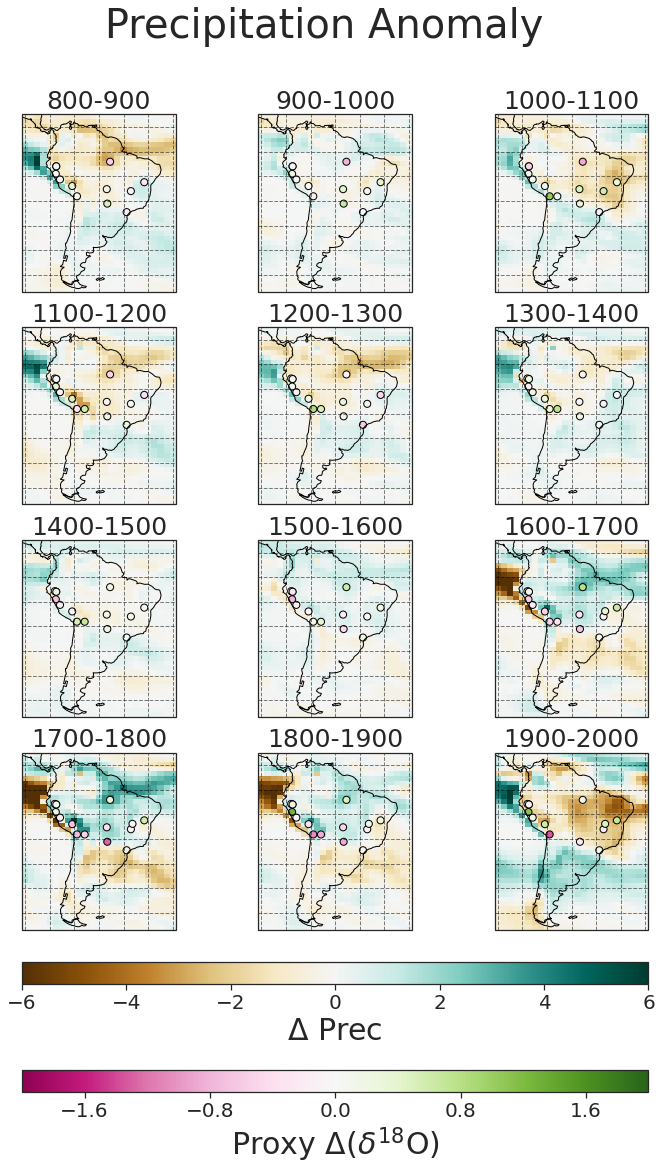

In [68]:
proxies=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_1700_1800_az.nc']
regional_plot(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_nopsm/iCESM.nc')['prec_mean'],bounds=bounds_sa,vmax=6,vmin=-6,
              title='Precipitation Anomaly',  cmap='BrBG',label=r'$\Delta$ Prec',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,size=50,
             maskocean=False)
#anomaly_period=['1700','1800']

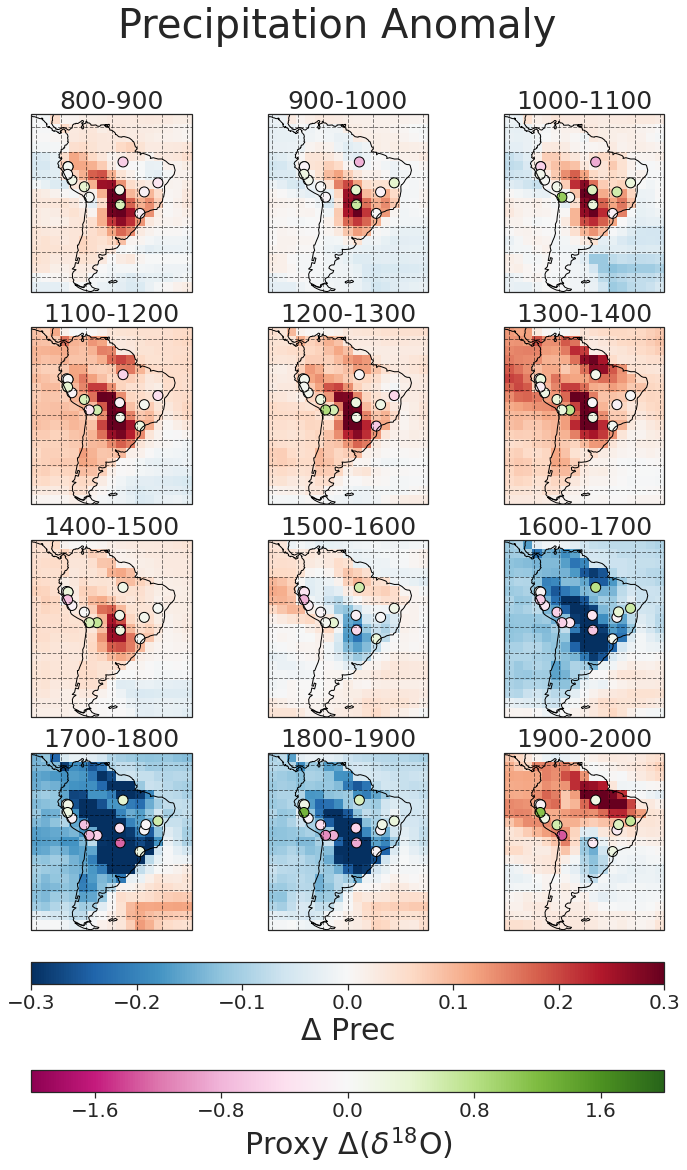

In [73]:
proxies=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_1700_1800_az.nc']
regional_plot(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_nopsm/Echam.nc')['tsurf_mean'],bounds=bounds_sa,
              vmax=0.3,vmin=-0.3,
              title='Precipitation Anomaly',  cmap='RdBu_r',label=r'$\Delta$ Prec',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,size=100,
             maskocean=False)
#anomaly_period=['1700','1800']

In [16]:
import matplotlib.patches as mpatches

In [40]:
bounds_europe=[[30,85],[310,50]]
bounds_global=[[-90,90],[0,360]]
bounds_sa=[[-57.5,15],[270,330]]
bounds_america=[[-60,30],[240,330]]
monsoon_region=[[-17.5,-5],[287.5,312.5]]

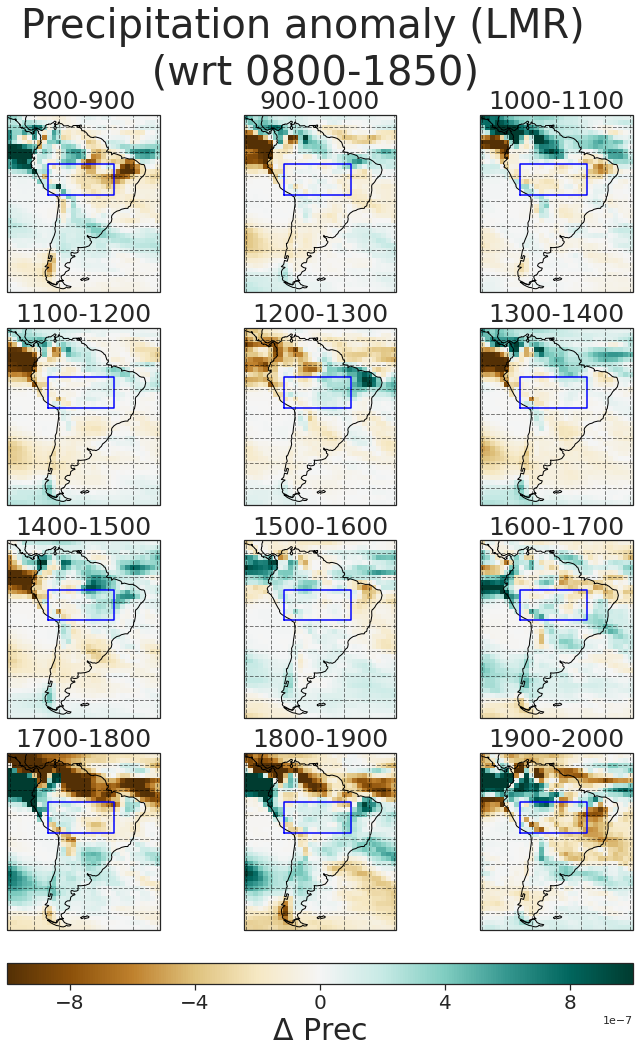

In [18]:
regional_plot(lmr_prec,bounds=bounds_sa,vmax=10**(-6),vmin=-10**(-6),
              title='Precipitation anomaly (LMR) \n (wrt 0800-1850)',  cmap='BrBG',label=r'$\Delta$ Prec',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=True,
             maskocean=False)

Text(0.5, 0, 'Year AD')

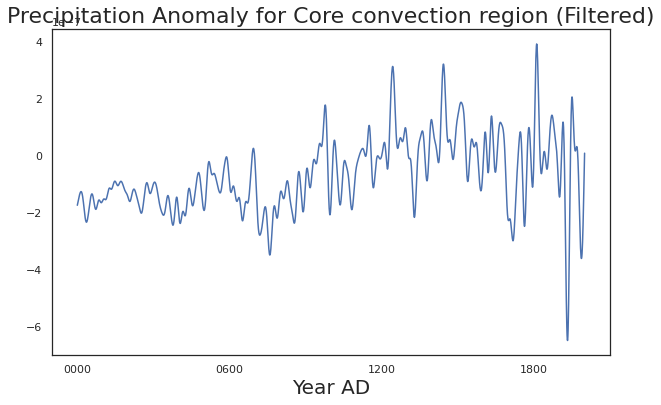

In [217]:
plt.figure(figsize=(10,6))
start=0
plt.plot(anomaly(lmr_prec,start='0800',end='1850')[start:].time,quick_filt(utils.regionalmean(anomaly(lmr_prec,start='0850',end='1850'),[-17.5,-5],[287.5,312.5])[start:],cutoff=1/30))
plt.title('Precipitation Anomaly for Core convection region (LMR,Filtered)',fontsize=22)
plt.xlabel('Year AD', fontsize=20)

Text(0.5, 0, 'Year AD')

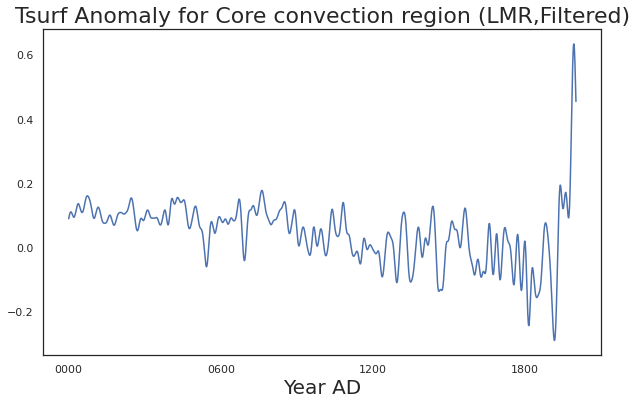

In [239]:
plt.figure(figsize=(10,6))
start=0
plt.plot(anomaly(lmr_tsurf['air'],start='0800',end='1850')[start:].time,quick_filt(utils.regionalmean(anomaly(lmr_tsurf['air'],start='0850',end='1850'),[-17.5,-5],[287.5,312.5])[start:],cutoff=1/30))
plt.title('Tsurf Anomaly for Core convection region (LMR,Filtered)',fontsize=22)
plt.xlabel('Year AD', fontsize=20)

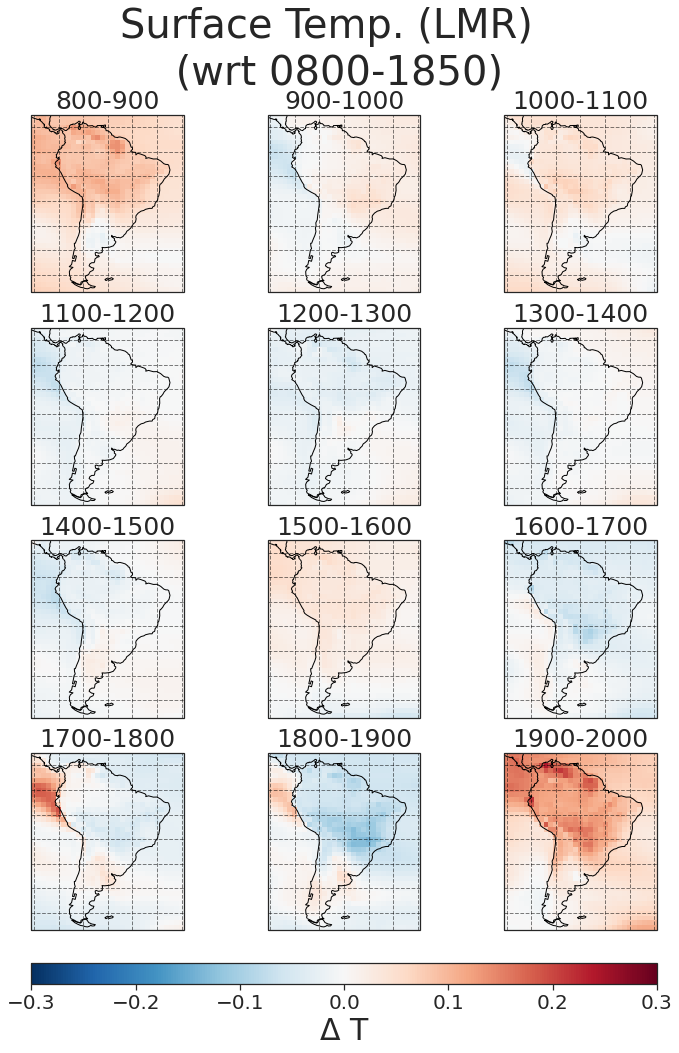

In [218]:
regional_plot(lmr_tsurf['air'],bounds=bounds_sa,vmax=0.3,vmin=-0.3,
              title='Surface Temp. (LMR) \n (wrt 0800-1850)',  cmap='RdBu_r',label=r'$\Delta$ T',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)

# Temperature and SPEI in PHYDA


In [220]:
phyda_path='/home/mchoblet/validation_data/phyda.nc'
phyda=xr.open_dataset(phyda_path)
LMR_gmt='/home/mchoblet/validation_data/gmt_MCruns_ensemble_full_LMRv2.1.nc'
lmr_gm=xr.open_dataset(LMR_gmt)
time_lmr=lmr_gm['time']
time_phyda=time_lmr[1:]
phyda['time']=time_phyda

In [224]:
phyda['tas_mn']

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 2000, tmon: 24000, prctl: 3)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time          (time) object 0001-01-01 00:00:00 ... 2000-01-01 00:00:00
  * tmon          (tmon) float64 1.0 1.083 1.167 ... 2.001e+03 2.001e+03
Dimensions without coordinates: prctl
Data variables: (12/63)
    tas_mn        (time, lat, lon) float64 ...
    tas_sg        (time, lat, lon) float64 ...
    tas_pc        (prctl, time, lat, lon) float64 ...
    pdsi_mn       (time, lat, lon) float64 ...
    pdsi_sg       (time, lat, lon) float64 ...
    pdsi_pc       (prctl, time, lat, lon) float64 ...
    ...            ...
    gmt_mn        (time) float64 14.91 15.02 15.04 15.02 ... 15.59 15.45 15.54
    gmt_sg        (time) float64 0.1696 0.1713 0.1713 ... 0.09663 0.09833
    gmt_pc        (prctl, time) float64 14.64 14.74 14.77 ... 15.73 15.59 15.69
    amo_mn        (time) float64 20.66 20.74 20.77 20.77 ... 21.35 21.1 21.17
    amo_sg        (time) float64 0.1716 0.1732 0.1732 ... 0.1085 0.114 0.1144
    amo_pc        (prctl, time) float64 20.37 20.44 20.48 ... 21.53 21.29 21.35
Attributes:
    history_of_appended_files:  Wed Mar 14 16:04:33 2018: Appended file ./inp...
    author:                     Nathan Steiger, LDEO Columbia University, Mar...
    history:                    Wed Mar 14 16:04:45 2018: ncatted -O --glb_at...
    NCO:                        "4.6.2"
    citation:                   https://doi.org/10.5281/zenodo.1154913

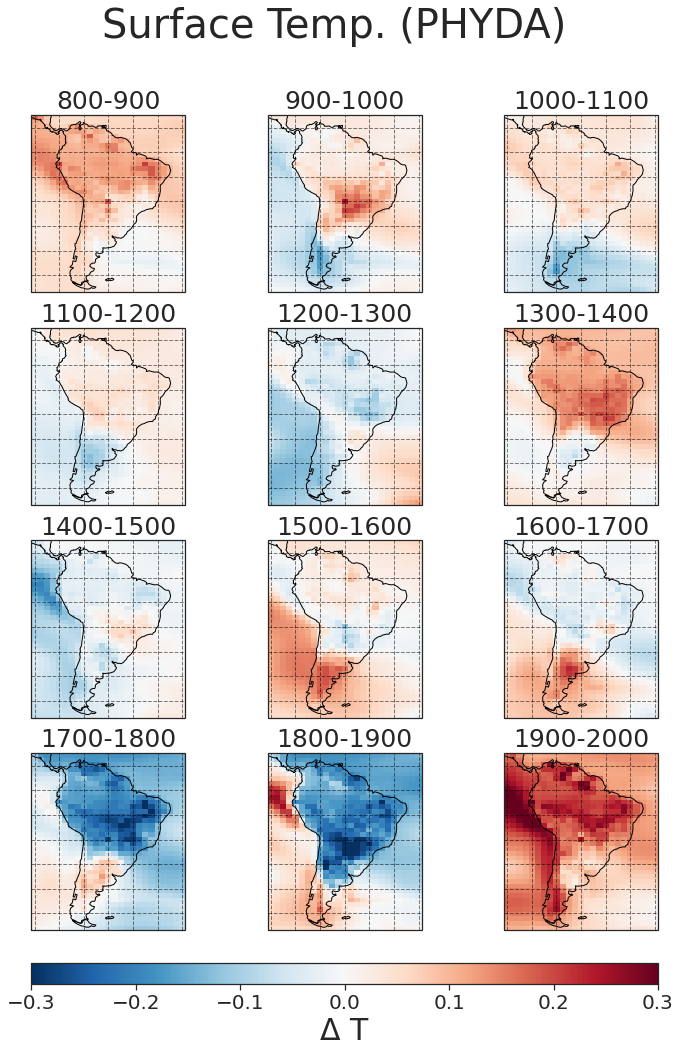

In [233]:
regional_plot(phyda['tas_mn'],bounds=bounds_sa,vmax=0.3,vmin=-0.3,
              title='Surface Temp. (PHYDA)',  cmap='RdBu_r',label=r'$\Delta$ T',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)

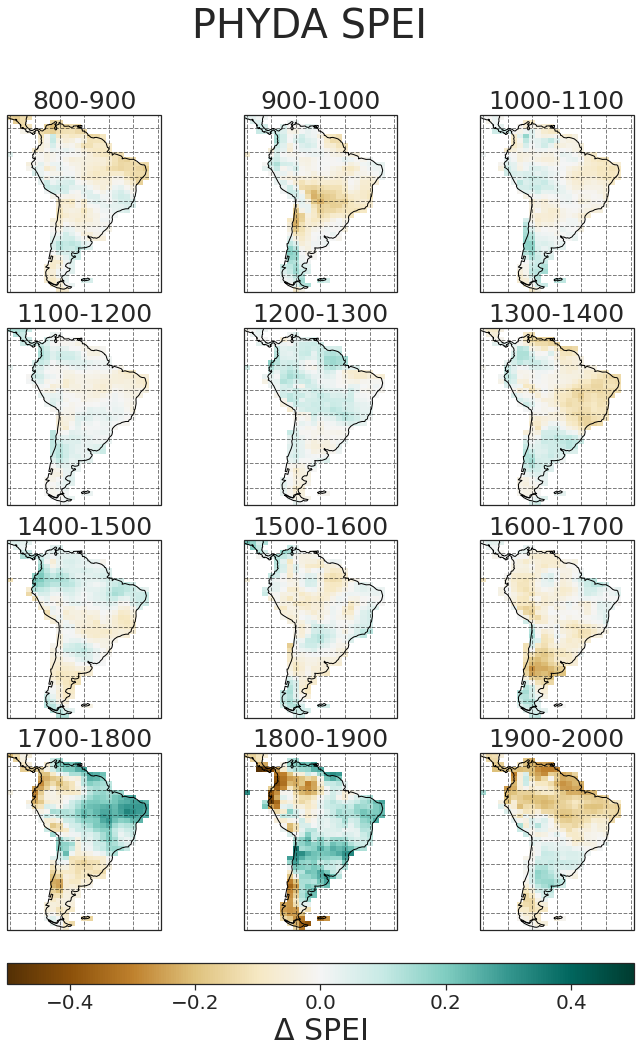

In [231]:
regional_plot(phyda['spei_mn'],bounds=bounds_sa,vmax=0.5,vmin=-0.5,
              title='PHYDA SPEI',  cmap='BrBG',label=r'$\Delta$ SPEI',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)

In [ ]:
phyda['t']

Text(0.5, 0, 'Year AD')

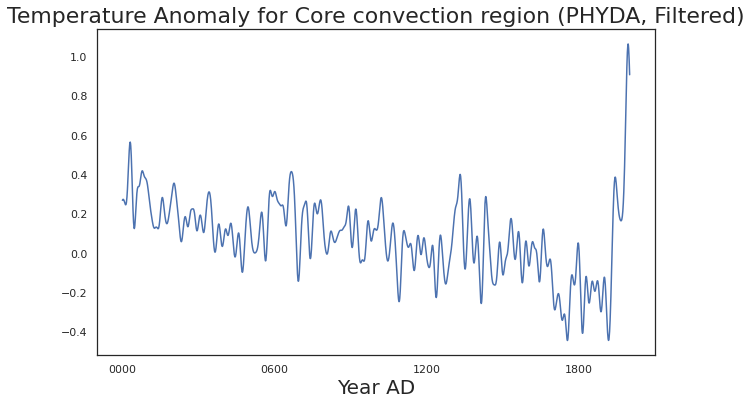

In [237]:
plt.figure(figsize=(10,6))
start=0
plt.plot(anomaly(phyda['tas_mn'],start='0800',end='1850')[start:].time,quick_filt(utils.regionalmean(anomaly(phyda['tas_mn'],start='0800',end='1850'),[-17.5,-5],[287.5,312.5])[start:],cutoff=1/30))
plt.title('Temperature Anomaly for Core convection region (PHYDA, Filtered)',fontsize=22)
plt.xlabel('Year AD', fontsize=20)

In [ ]:
phyda['spei_mn']

# Rebecca Orrison Paper 2022: iCESM MCA/LIA - Last Millennium 
 ![Proxy locations in LMR](https://cp.copernicus.org/articles/18/2045/2022/cp-18-2045-2022-f05-web.png)


**Figure 5** iCESM full-forcing multi-model mean anomalies during the MCA (850–1160 CE; a, c, e) and LIA (1489–1850 CE; b, d, f) relative to the full LM (850–1850 CE) mean in austral summer (DJF) for (a, b) mid-tropospheric vertical velocity (500 hPa, Pa s−1; note that negative anomalies signify enhanced upward motion and reduced subsidence), (c, d) precipitation-weighted δ18O (permil; colored circles represent values from proxy MC 1000-member ensemble mean; note that color scales differ between proxy and model estimates), and (e, f) precipitation (mm d−1). Stippling indicates regions where anomalies are significant at p≤0.1.

# My proxies -> See Proxy selection notebook

# Reconstructions (Global, but only with restricted ice core and sisal selection)
- Time: 0000-1999 (or 0500 - 1999)
- Test both no psm and psm (without filter, just frac and infiltration weighting) (2)
- Run for all models separately, the multi-model-ensemble, and the multi-model no Giss ensemble (7)
- reuse proxies on multiple time scales
- First: Everything together (ice cores + speleothems). Multi-Model Ensemble and iCESM (that's also the phyda model, without the isotopes)

- timescales= [1,5,10,20,100]
- proxy error= [0.5,0.5]
- reference period= [1700,1800]

In [5]:
#upsampled multiprior
multi_prior_up={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_inf_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_inf_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/upsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_inf_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       }
}

paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
} 


oro_dic={
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
}


In [6]:
#CONFIG DICTIONARY (NEW)

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales
cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'reconstruct':['tsurf','d18O','prec','evap','inf'],
'basepath':'/home/mchoblet/paleoda/', #dont forget last slash
'output_folder':'thesis_6_2', #in cwd
'output_file':'Echam_realistic_PPE_snr1',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':True, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']],
'how_many': None, 
'only_regional_proxies':False,
'regional_bounds':False,
'proxy_error': [0.5,0.5], 
'time_scales': ['median','median'],
'proxy_time':['0000','2013'],
'resample': True,
'resample_mode': 'linear',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1,5,10,20,100], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,

#'psm':['speleo','icecore'], 
'psm':[None,None], 
'interpol':None, #None/'dw'
'var_psm': ['d18O','d18O'] ,
#irrelevant if psm=none
'speleo':{
    'weighting': 'inf',#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},

###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': False,
    },


###KALMAN-FILTER
'time': ['0500','1999'],
'nens':100, #ensemble members
'reps':10, #Monte Carlo
'full_fields': True, 
'proxy_frac': None,
'extra_assi': 
    {
        'globalmean': None, #['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': None, #['tsurf'], #None, #['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #'BG+HX', #/ 'HX'
'anomaly_time': ['1700','1800'],#None, #['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

# The 10 Year Experiment: 
- 11 SISAL south america, 7 SISAL Middle America and Quelccaya record
- give a small error, 0.2
- regional reconstruction: Lons: 240 - 330, Lats: -60 - 30
- For the multi-model ensemble use the highest resolution
- Reconstruct Years: 500-1999
- the light PSM
- **Most important:** All records are resampled to 10 Years (except for Quelcaya, which is the annual alibi record)

In [7]:
#### SOUTH AMERICA + CENTRAL AMERICA

cfg['output_folder']='thesis_6_2_10year_noreuse'
cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az_10.nc','/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_ma.nc','/home/mchoblet/paleoda/data/proxy_dbs/quelcaya_az.nc']
cfg['timescales']=[1,10]
cfg['obs_var']=[['d18O','d18O_precision'],['d18O','d18O_precision'],['d18O','d18O_precision']]
cfg['psm']=['speleo','speleo','icecore']
cfg['var_psm']=['d18O', 'd18O','d18O']
cfg['proxy_error']=[0.2,0.2,0.2]
cfg['regional_bounds']=[[-60,30],[240,330]]
cfg['time_scales']=[10,10,1]
cfg['proxy_time']=['0500','1999']
cfg['time']=['0500','1999']
cfg['reuse']=False
                        
#paths=multi_prior_up
#loop over proxy origin
for i, model in enumerate(paths.keys()):
    #pseudoproxy source
    cfg_exp=copy.deepcopy(cfg)
    cfg_exp['multi_model_prior']=None

    if model=='iHadCM3':
        cfg_exp['check_nan']=True
    else:
        cfg_exp['check_nan']=False

    cfg_exp['vp']=paths[model]
    cfg_exp['output_file']=model
    wrapper.paleoda_wrapper(cfg_exp)

cfg_exp=copy.deepcopy(cfg)                        
#MULTI-MODEL-ENSEMBLE
cfg_exp['nens']=100
cfg_exp['reps']=10
copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths

cfg_exp['output_file']='mme'
wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE (no GISS)
copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

cfg_exp['output_file']='mme_nogiss'
wrapper.paleoda_wrapper(cfg_exp)    

##################### NO CENTRAL AMERICA, ONLY SOUTH AMERICA AND QUELCAYA
cfg['output_folder']='thesis_6_2_10year_only_SA'
cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az_10.nc','/home/mchoblet/paleoda/data/proxy_dbs/quelcaya_az.nc']
cfg['timescales']=[1,10]
cfg['obs_var']=[['d18O','d18O_precision'],['d18O','d18O_precision']]
cfg['psm']=['speleo','icecore']
cfg['var_psm']=['d18O', 'd18O']
cfg['proxy_error']=[0.2,0.2]
cfg['regional_bounds']=[[-60,30],[240,330]]
cfg['time_scales']=[10,1]
cfg['proxy_time']=['0500','1999']
cfg['time']=['0500','1999']
cfg['reuse']=True
                        
#paths=multi_prior_up
#loop over proxy origin
for i, model in enumerate(paths.keys()):
    #pseudoproxy source
    cfg_exp=copy.deepcopy(cfg)
    cfg_exp['multi_model_prior']=None

    if model=='iHadCM3':
        cfg_exp['check_nan']=True
    else:
        cfg_exp['check_nan']=False

    cfg_exp['vp']=paths[model]
    cfg_exp['output_file']=model
    wrapper.paleoda_wrapper(cfg_exp)

cfg_exp=copy.deepcopy(cfg)                        
#MULTI-MODEL-ENSEMBLE
cfg_exp['nens']=100
cfg_exp['reps']=10
copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths

cfg_exp['output_file']='mme'
wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE (no GISS)
copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

cfg_exp['output_file']='mme_nogiss'
wrapper.paleoda_wrapper(cfg_exp)    

###### ONLY CENTRAL AMERICA 
# -> I need at least annual record due to code, need to fix that (but that's not so obvious ...)

>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [09:08<00:00, 54.84s/it]


Finished multitimescale DA
Save variables
Output written to iCESM.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [10:42<00:00, 64.23s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [04:00<00:00, 24.06s/it]


Finished multitimescale DA
Save variables
Output written to Echam.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA lo

100%|██████████| 10/10 [07:49<00:00, 46.91s/it]


Finished multitimescale DA
Save variables
Output written to GISS.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load inf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in

100%|██████████| 10/10 [03:43<00:00, 22.34s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_

100%|██████████| 10/10 [1:23:18<00:00, 499.82s/it]


Finished multitimescale DA
Save variables
Output written to mme.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_

100%|██████████| 10/10 [1:38:16<00:00, 589.61s/it]


Finished multitimescale DA
Save variables
Output written to mme_nogiss.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [09:07<00:00, 54.77s/it]


Finished multitimescale DA
Save variables
Output written to iCESM.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [13:31<00:00, 81.20s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [03:16<00:00, 19.68s/it]


Finished multitimescale DA
Save variables
Output written to Echam.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [08:44<00:00, 52.44s/it]


Finished multitimescale DA
Save variables
Output written to GISS.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load inf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in

100%|██████████| 10/10 [03:57<00:00, 23.77s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851

100%|██████████| 10/10 [43:50<00:00, 263.06s/it]


Finished multitimescale DA
Save variables
Output written to mme.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851

100%|██████████| 10/10 [33:31<00:00, 201.12s/it]


Finished multitimescale DA
Save variables
Output written to mme_nogiss.nc


<xarray.Dataset>
Dimensions:         (lat: 48, lon: 49, time: 1500, model: 4, reps: 10,
                     nens: 100, site: 12, bs: 10, time_res_1: 1500, site_1: 1,
                     time_res_10: 150, site_10: 12)
Coordinates:
  * lat             (lat) float64 29.52 27.62 25.71 ... -56.19 -58.09 -60.0
  * lon             (lon) float64 240.0 241.9 243.8 245.6 ... 326.2 328.1 330.0
  * time            (time) object 0500-01-01 00:00:00 ... 1999-01-01 00:00:00
    MC_idx          (model, reps, nens) int64 424 912 649 440 ... 91 1094 450
  * site            (site) <U5 '0.3' '0.10' '0.25' ... '0.235' '0.277' '1.49'
  * time_res_1      (time_res_1) object 0500-01-01 00:00:00 ... 1999-01-01 00...
  * site_1          (site_1) <U4 '1.49'
  * time_res_10     (time_res_10) object 0500-01-01 00:00:00 ... 1990-01-01 0...
  * site_10         (site_10) <U5 '0.3' '0.10' '0.25' ... '0.235' '0.277' '1.49'
Dimensions without coordinates: model, reps, nens, bs
Data variables: (12/20)
    tsurf_mean      (time, lat, lon) float64 0.08363 0.1086 ... 0.2443 0.2324
    tsurf_std       (time, lat, lon) float64 0.5331 0.5184 ... 0.8624 0.8601
    d18O_mean       (time, lat, lon) float64 -0.04666 0.04543 ... -0.01323
    d18O_std        (time, lat, lon) float64 0.7207 0.6919 ... 0.3851 0.3908
    prec_mean       (time, lat, lon) float64 0.2684 0.3549 ... -0.03926 0.04305
    prec_std        (time, lat, lon) float64 5.091 5.573 6.546 ... 4.779 4.83
    ...              ...
    proxies_res_1   (time_res_1, site_1) float64 0.6986 0.9336 ... 0.9523 -1.495
    proxies_res_10  (time_res_10, site_10) float64 -0.9174 1.445 ... 0.297 1.966
    proxies         (time, site) float64 nan -3.474 nan nan ... nan nan -20.25
    proxies_r       (time, site) float64 nan 0.2 nan nan nan ... nan nan nan 0.2
    proxies_lat     (site) float64 -4.067 -21.08 -5.92 ... -5.941 -11.27 -13.93
    proxies_lon     (site) float64 304.6 303.4 282.6 313.0 ... 282.7 284.2 289.2
Attributes:
    prior:    [{'grid_mapping': 'spatial_ref'}, {'units': 'mm/month'}, {}, {'...
    cfg:      {'vp': {'d18O': '/home/mchoblet/paleoda/data/model_data/ECHAM5_...

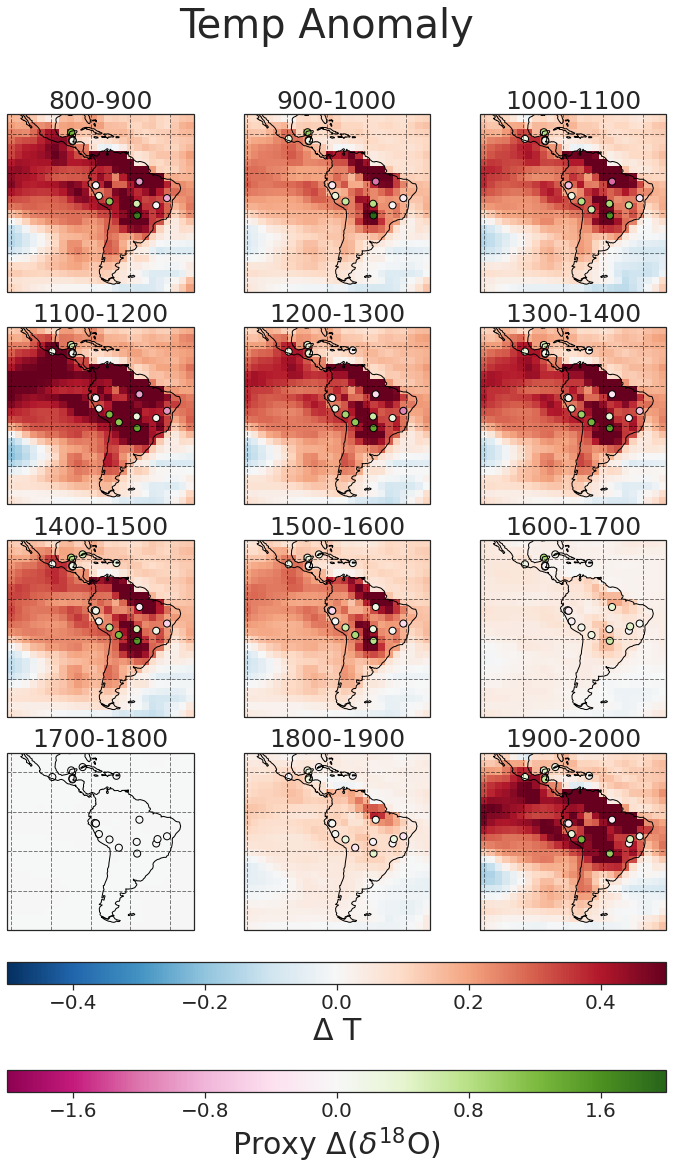

In [47]:
proxies=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az_10.nc','/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_ma.nc','/home/mchoblet/paleoda/data/proxy_dbs/quelcaya_az.nc']
regional_plot(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year/Echam.nc')['tsurf_mean'],bounds=bounds_america,vmax=0.5,vmin=-0.5,
              title='Temp Anomaly',  cmap='RdBu_r',label=r'$\Delta$ T',
              figsize=(12,15),plotbox=False,size=50,
              #anomaly_period=['0800','1850'],
              anomaly_period=['1700','1800'],
             maskocean=False)
#anomaly_period=['1700','1800']

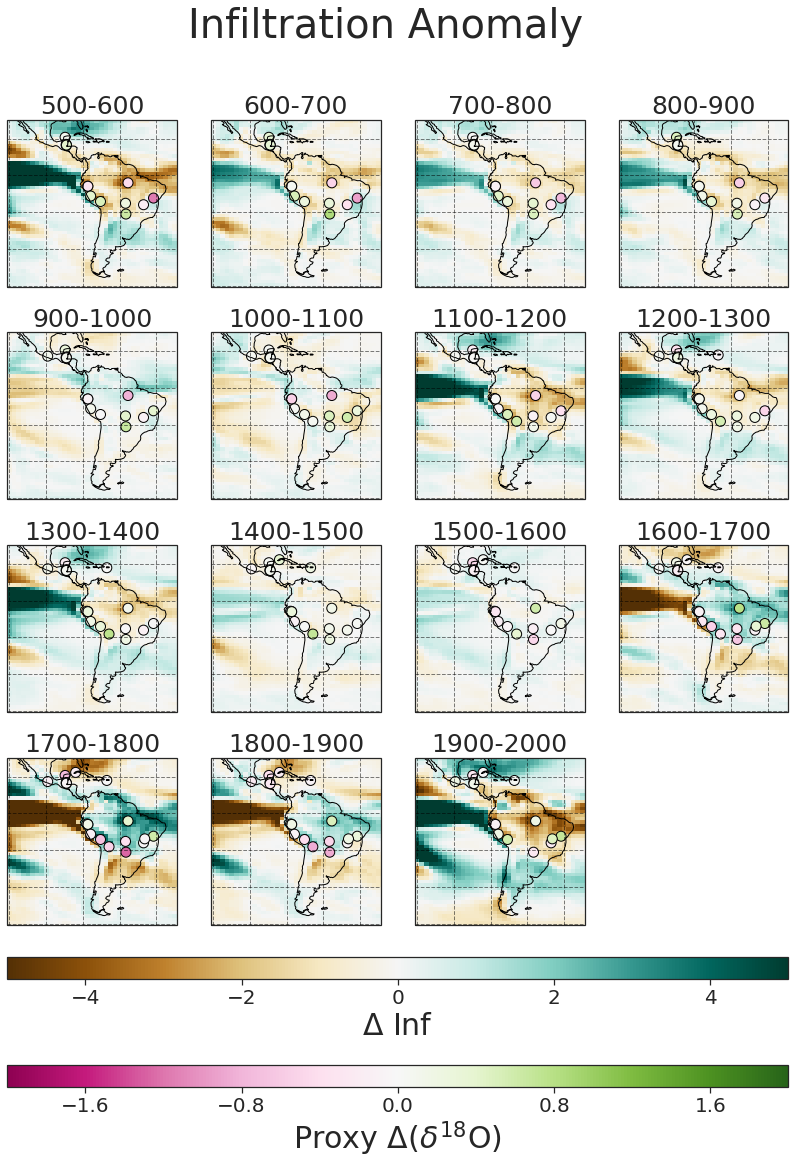

In [103]:
proxies=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az_10.nc','/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_ma.nc','/home/mchoblet/paleoda/data/proxy_dbs/quelcaya_az.nc']
vmax=5
#vmax=0.5

#set model and and varable -> get plot

regional_plot(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year/iCESM.nc')['prec_mean'],bounds=bounds_america,vmax=vmax,vmin=-vmax,
              title='Infiltration Anomaly',  
              #cmap='RdBu_r',
              cmap='BrBG',
              label=r'$\Delta$ Inf',
              #label=r'$\Delta$ T',
              figsize=(14,15),plotbox=False,
              start_y='0500',
              anomaly_period=['0800','1850'],
              #anomaly_period=['1700','1800'],
              proxies=proxies,
              size=100,
              #proxies=None,
             maskocean=False)
            #maskocean=False)
#anomaly_period=['1700','1800']

In [60]:
vmax=10
regional_plot(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year/iCESM.nc')['prec_mean'],bounds=bounds_america,vmax=vmax,vmin=-vmax,
              title='Infiltration Anomaly',  
              #cmap='RdBu_r',
              cmap='BrBG',
              label=r'$\Delta$ Inf',
              #label=r'$\Delta$ T',
              figsize=(12,15),plotbox=False,size=50,
              #anomaly_period=['0800','1850'],
              anomaly_period=['1700','1800'],
            proxies=False,
              maskocean=False)
            #maskocean=False)
#anomaly_period=['1700','1800']

TypeError: 'bool' object is not iterable

# Regular Experiment with more timescales and reusing

In [107]:
def experiment_6_2(cfg):
    #paths=multi_prior_up
    #loop over proxy origin
    for i, model in enumerate(paths.keys()):
        #pseudoproxy source
        cfg_exp=copy.deepcopy(cfg)
        cfg_exp['multi_model_prior']=None

        if model=='iHadCM3':
            cfg_exp['check_nan']=True
        else:
            cfg_exp['check_nan']=False

        cfg_exp['vp']=paths[model]
        cfg_exp['output_file']=model
        wrapper.paleoda_wrapper(cfg_exp)

    #MULTI-MODEL-ENSEMBLE
    cfg_exp['nens']=50
    cfg_exp['reps']=10
    copied_paths=copy.deepcopy(multi_prior_up)
    cfg_exp['multi_model_prior']=copied_paths

    cfg_exp['output_file']='mme'
    wrapper.paleoda_wrapper(cfg_exp)

    #MULTI-MODEL-ENSEMBLE (no GISS)
    copied_paths=copy.deepcopy(multi_prior_up)
    cfg_exp['multi_model_prior']=copied_paths
    del copied_paths['GISS']

    cfg_exp['output_file']='mme_nogiss'
    wrapper.paleoda_wrapper(cfg_exp)    

In [ ]:
#including central america

cfg['timescales']=[1,5,10,20,50,100]
cfg['reuse']=True
cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az.nc','/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_ma.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_1700_1800_az.nc']
cfg['obs_var']=[['d18O','d18O_precision'],['d18O','d18O_precision'],['d18O','d18O_precision']]
cfg['psm']=['speleo','speleo','icecore']
cfg['proxy_error']=[0.5,0.5,0.5]
cfg['regional_bounds']=[[-60,30],[240,330]]
cfg['time_scales']=['median','median','median']
cfg['output_folder']='thesis_6_2_regular'

experiment_6_2(cfg)



>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [18:02<00:00, 108.25s/it]


Finished multitimescale DA
Save variables
Output written to iCESM.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [22:00<00:00, 132.04s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [06:45<00:00, 40.54s/it]


Finished multitimescale DA
Save variables
Output written to Echam.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  5.21it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA lo

100%|██████████| 10/10 [17:13<00:00, 103.39s/it]


Finished multitimescale DA
Save variables
Output written to GISS.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load inf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in

100%|██████████| 10/10 [10:31<00:00, 63.19s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_

 20%|██        | 2/10 [15:46<1:03:30, 476.34s/it]

In [ ]:
##only south america

cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az_10.nc','/home/mchoblet/paleoda/data/proxy_dbs/quelcaya_az.nc']
cfg['obs_var']=[['d18O','d18O_precision'],['d18O','d18O_precision']]
cfg['psm']=['speleo','icecore']
cfg['var_psm']=['d18O', 'd18O']
cfg['proxy_error']=[0.5,0.5]
cfg['time_scales']=['median','median']
cfg['output_folder']='thesis_6_2_regular_only_SA'

experiment_6_2(cfg)

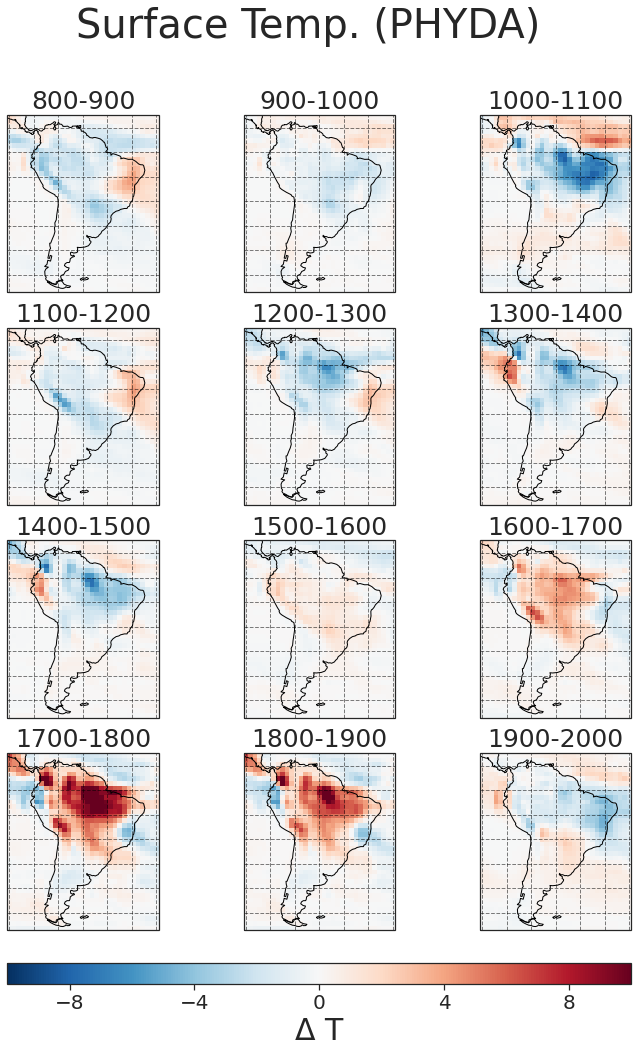

In [27]:
regional_plot(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2/mme.nc')['prec_mean'],bounds=bounds_sa,vmax=10,vmin=-10,
              title='Surface Temp. (PHYDA)',  cmap='RdBu_r',label=r'$\Delta$ T',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)

In [ ]:
#test multi-ensemble repetitions with 


cfg['psm']=[None,None]
cfg['nens']=50
cfg['reps']=10
#cfg['regional_bounds']=bounds_sa
cfg_exp=copy.deepcopy(cfg)

#MULTI-MODEL-ENSEMBLE
copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths

cfg_exp['output_file']='mme'
wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE (no GISS)
copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

cfg_exp['output_file']='mme_nogiss'
wrapper.paleoda_wrapper(cfg_exp)    

>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  8.90it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE

 20%|██        | 2/10 [30:54<2:03:40, 927.54s/it]

In [ ]:
# Second, Light PSM:
# first, no psm
cfg['output_folder']='thesis_6_2_psm'

# Precipitation/infiltration weighting + fractionation
cfg['psm']=['speleo','icecore']
cfg['speleo']={'weighting': 'inf',
 'height': False,
 'fractionation': True,
 'fractionation_temp': 'regular',
 'filter': False,
 't_time': 2.5}
cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}
experiment_6_2(cfg)

>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  8.89it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [04:22<00:00, 262.25s/it]


Finished multitimescale DA
Save variables
Output written to iCESM.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [05:43<00:00, 343.91s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:20<00:00, 80.55s/it]


Finished multitimescale DA
Save variables
Output written to Echam.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  8.90it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [04:07<00:00, 247.49s/it]


Finished multitimescale DA
Save variables
Output written to GISS.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans 

100%|██████████| 1/1 [01:59<00:00, 119.88s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 3/3 [00:00<00:00,  8.73it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_8

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Second, Light PSM:
# first, no psm
cfg['output_folder']='thesis_6_2_psm'
cfg['nens']=50
cfg['reps']=10

cfg['psm']=['speleo','icecore']
# Precipitation/infiltration weighting + fractionation
cfg['speleo']={'weighting': 'inf',
 'height': False,
 'fractionation': True,
 'fractionation_temp': 'regular',
 'filter': False,
 't_time': 2.5}
cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

#cfg['regional_bounds']=bounds_sa
cfg_exp=copy.deepcopy(cfg)

#MULTI-MODEL-ENSEMBLE
copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths

cfg_exp['output_file']='mme'
wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE (no GISS)
copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

cfg_exp['output_file']='mme_nogiss'
wrapper.paleoda_wrapper(cfg_exp)    

In [ ]:
cfg['reuse']=False
cfg['proxy_error']=[0.2,0.2] 

# Second, Light PSM:
# first, no psm
cfg['output_folder']='thesis_6_2_psm_noreuse'

# Precipitation/infiltration weighting + fractionation
cfg['psm']=['speleo','icecore']
cfg['speleo']={'weighting': 'inf',
 'height': False,
 'fractionation': True,
 'fractionation_temp': 'regular',
 'filter': False,
 't_time': 2.5}
cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}
experiment_6_2(cfg)